<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Copia_di_Adversarial_Diffusion_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cose da fare

L'obbiettivo di tutto il modello è quello di rendere l'ADD student il più bravo possibile  ma con un numero molto piccolo di istanti in cui viene fatto il denoising.
Utilizziamo quindi lo stesso modello per il teacher  e poer lo student ma allo student diamo solo da 1 a 4 istanti di denoising e lo aggiorniamo con la loss in modo che impari a predire le immagini giuste nel minor tempo possibile

*   Importare il dataset e preprocessing
*   Realizzare il Discriminator(ViT) e pretrainarlo da zero e salvarne i weights, importarne i weights e visto ceh le performance saranno scarse prova ad utilizzare un vit_b_16 pretrainato
*   Realizzare il forward process che aggiunge il noise all'immagine
*   Realizzare il denoise process (ADD-Student) che toglie il rumore dell'immagine e genera la nuova immagine
*   Calcolare la Discriminator Loss (condizionarla all'immagine iniziale utilizzando un dino model)
*   Riaggiungere il rumore all'immagine generata dallo Student
*   Utilizzare il DM-Teacher per ricostruire una nuova immagine(ricordati che non deve essere trainato)
*   Calcolare la distillation Loss
##RISOLVERE I PROBLEMI


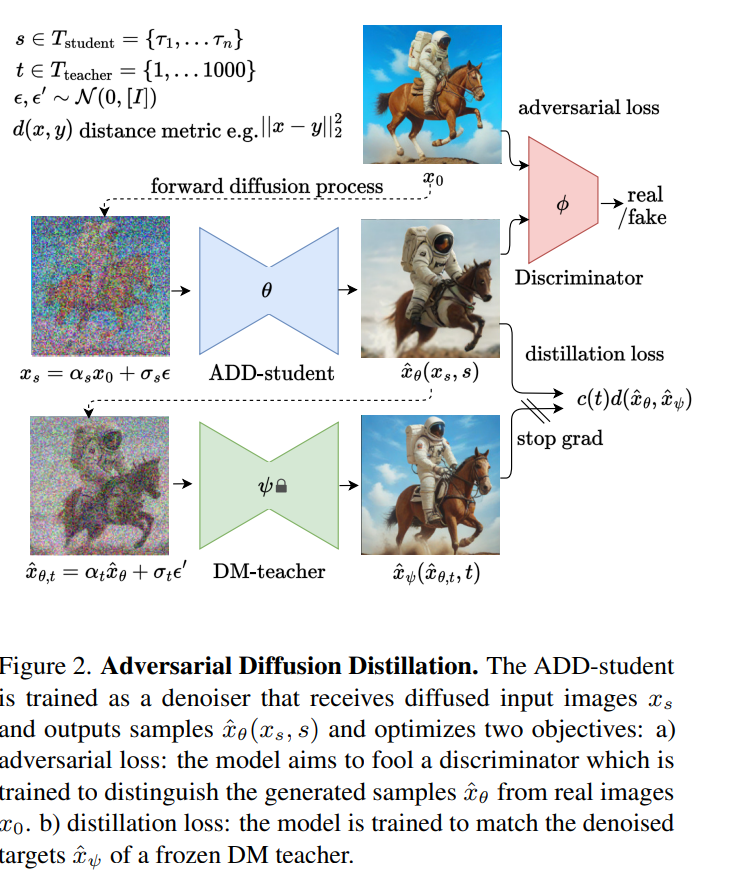









https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


#Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.optim import Adam

BATCH_SIZE=128

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 9868254.58it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175464.66it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3244335.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22970507.44it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [4]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(24, 24))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:32][0], nrow=8).permute(1, 2, 0))
        break

torch.Size([128, 1, 28, 28])


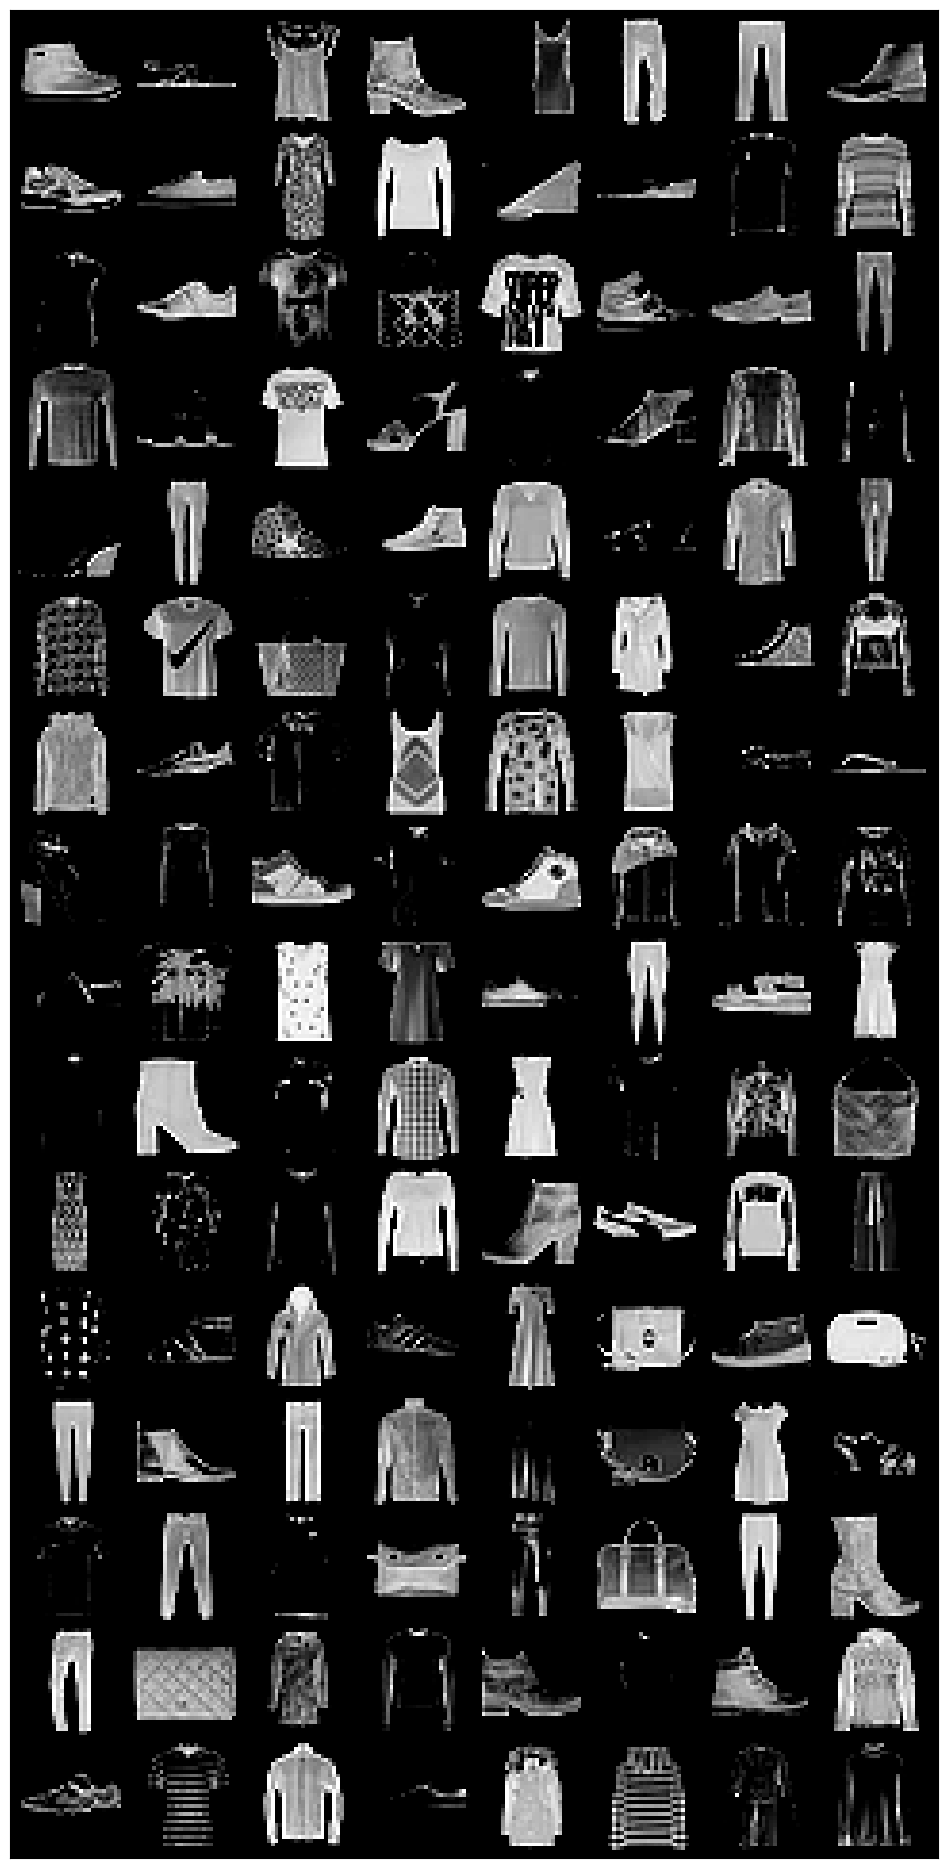

In [5]:
show_batch(dataloader)

In [6]:
#time schedule
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [7]:
IMG_SIZE = 28

def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([128, 1, 28, 28])


<ipython-input-8-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


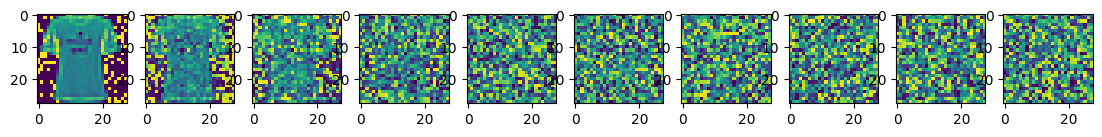

In [8]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# UNet

La UNet viene utilizzata per fare in modo che il modello impari solo le parti più importanti dell'immagini tralasciando i dettagli



##UNeT

In [9]:
#Utilities

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #concatenazione
        return embeddings

In [11]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

DEVI UNIFICARE QUESTA ATTENTION CON L'ALTRA

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k) #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [13]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,#rgb
        with_time_emb=True,
        resnet_block_groups=4,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),


                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

##Train

In [14]:
# load dataset from the hub
image_size = 28
channels = 1
batch_size = 128

device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)

optimizer = Adam(diffusion_model.parameters(), lr=1e-3)

In [36]:
from torchvision.utils import save_image
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

epochs = 10
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 100

optimizer = Adam(diffusion_model.parameters(), lr=1e-4)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      #genera sample e calcola loss

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 100 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

Epoch: 0   Loss: 0.02611440233886242
Epoch: 0   Loss: 0.03251221030950546
Epoch: 0   Loss: 0.0274671483784914
Epoch: 0   Loss: 0.024425581097602844
Epoch: 0   Loss: 0.02712559700012207
Epoch: 1   Loss: 0.037638094276189804
Epoch: 1   Loss: 0.02873419225215912
Epoch: 1   Loss: 0.02713128924369812
Epoch: 1   Loss: 0.026406053453683853
Epoch: 1   Loss: 0.02383928745985031
Epoch: 2   Loss: 0.025127526372671127
Epoch: 2   Loss: 0.024421390146017075
Epoch: 2   Loss: 0.027967698872089386
Epoch: 2   Loss: 0.033040571957826614
Epoch: 2   Loss: 0.025321312248706818
Epoch: 3   Loss: 0.03009963221848011
Epoch: 3   Loss: 0.026384688913822174
Epoch: 3   Loss: 0.031294964253902435
Epoch: 3   Loss: 0.03644648939371109
Epoch: 3   Loss: 0.03261420875787735
Epoch: 4   Loss: 0.02387089654803276
Epoch: 4   Loss: 0.027383621782064438
Epoch: 4   Loss: 0.028923705220222473
Epoch: 4   Loss: 0.032463300973176956
Epoch: 4   Loss: 0.031903985887765884
Epoch: 5   Loss: 0.026720324531197548
Epoch: 5   Loss: 0.02508

In [37]:
path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
torch.save(diffusion_model.state_dict(), path)

##Generate new samples

In [21]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    #img = torch.randn(shape, device=device)
    imgs = []

    for i in reversed(range(0, timesteps)):   #tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=3):  #QUELLO SU CUI DEVI LAVORARE E' TIMESTEPS PERCHè NEL DM-TEACHER PUò ESSERE 500 MA NEL ADD DEVE ESSERE 1-4
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

In [18]:
timesteps = 500
samples = sample(diffusion_model, image_size=image_size,  timestep=timesteps, batch_size=BATCH_SIZE, channels=channels)

TypeError: sample() missing 1 required positional argument: 'img'

In [ ]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

image_data = samples[-1][random_index].reshape(image_size, image_size, channels)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float
image_data_normalized = image_data / np.max(image_data)

# Visualizza l'immagine normalizzata
plt.imshow(image_data_normalized)
plt.show()
print(len(samples[-1]))#samples = [200,128,1,28,28]

# ViT

In [22]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x) #abbiamo le patches
        return x


In [23]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [24]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [25]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(128, 256, 1, 1).to(device)

In [28]:
num_epochs=5
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-3)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch_size,), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)

        fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=timesteps,  batch_size=BATCH_SIZE, channels=channels)


        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        #if step % 100 == 0:
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.2272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

KeyboardInterrupt: 

In [30]:
path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), path)

Traina il diffusion model e salva i pesi sul drive

Carica i pesi dal drive

Usalo per addestrare il vit

Crea la pipeline che:

*   prende un immagine
*   aggiunge noise
*   Esegue il denoise
*   calcola l'adversarial loss (prende in input l'uscita del modello condiziona l'input all'immagine iniziale e lo passa al ViT)
*   alla denoised image riaggiungo noise e la passo per il DM-Teacher
*   calcoli la distillation loss





# Full Train

In [93]:
image_size = 28
channels = 1
batch_size = 128
student_timesteps = 50
teacher_timesteps= 500

In [ ]:
# Specifica il percorso nel tuo Google Drive dove hai salvato il modello
diffusion_path = '/content/drive/MyDrive/diffusion_model.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'


# Carica il teacher_model
teacher_model = Unet(dim=image_size,channels=1, dim_mults=(1, 2, 4))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Carica il discriminator_model
discriminator_model = ViT(128, 256, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.to(device)

# Carica il teacher_model
student_model = Unet( dim=image_size, channels=1, dim_mults=(1, 2, 4))
student_model.load_state_dict(torch.load(diffusion_path))
student_model.train()
student_model.to(device)

torch.Size([128, 1, 28, 28])


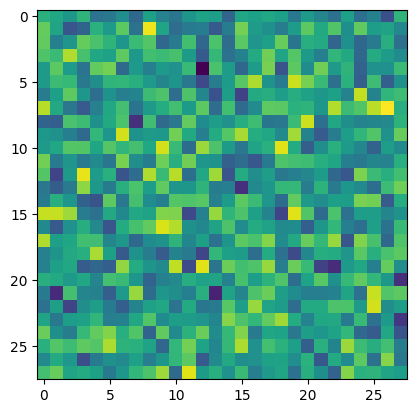

55


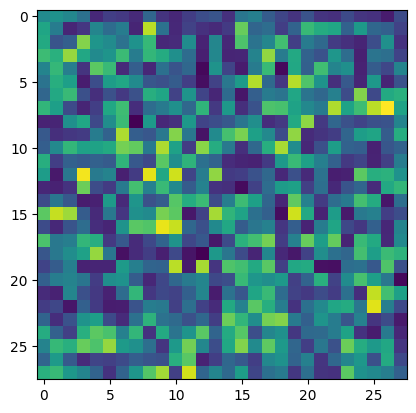

Epoch: 0  Adversarial Loss:tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>)


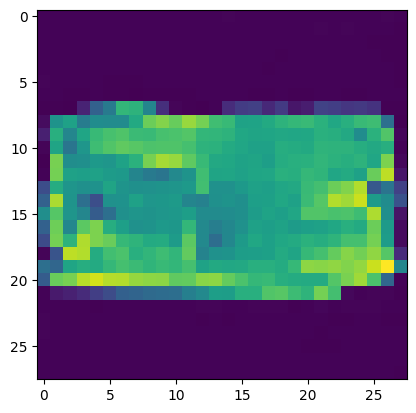

Epoch: 0   Loss: tensor(1.5832, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6294, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


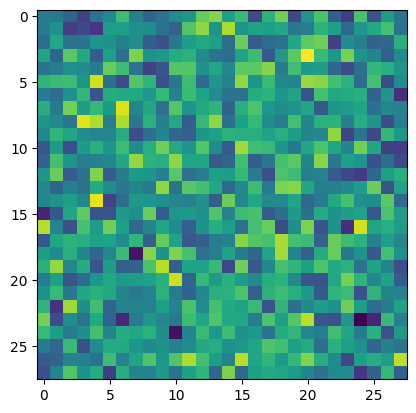

120


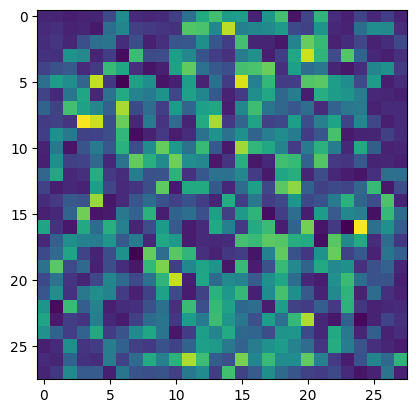

Epoch: 0  Adversarial Loss:tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


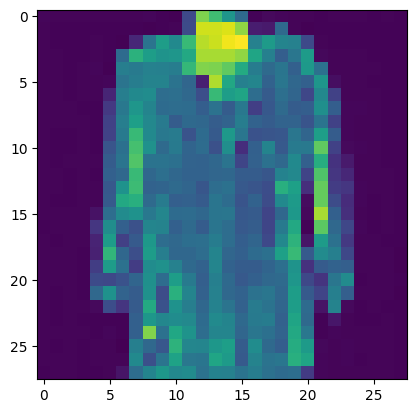

Epoch: 0   Loss: tensor(1.6780, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6592, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


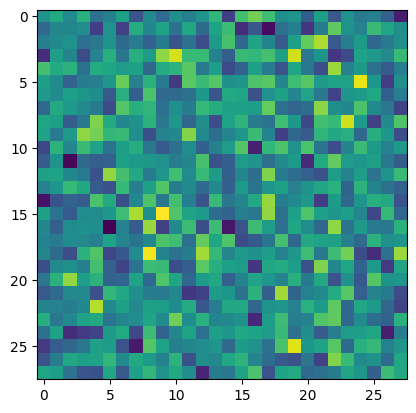

35


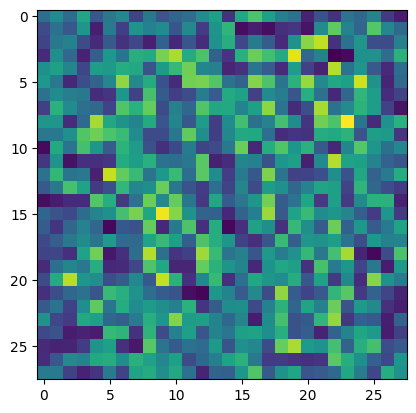

Epoch: 0  Adversarial Loss:tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)


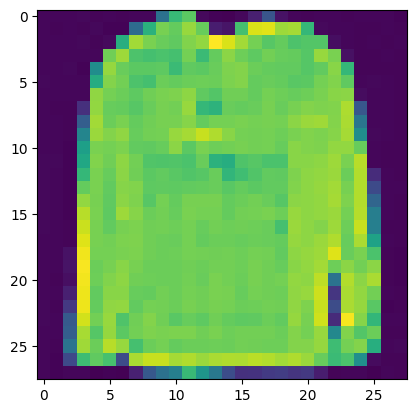

Epoch: 0   Loss: tensor(1.6286, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6475, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


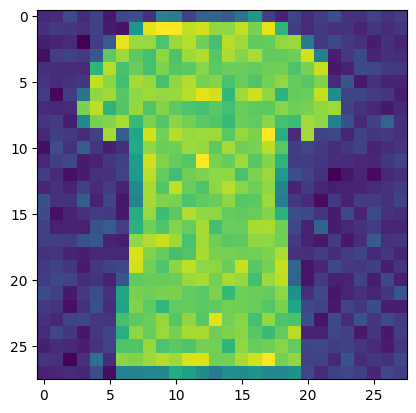

104


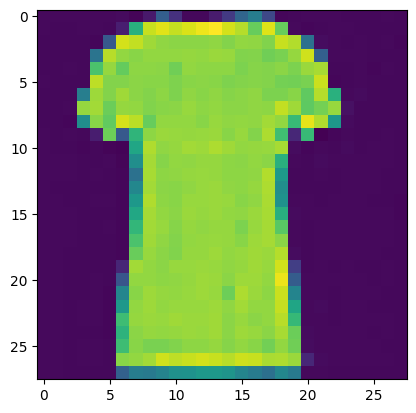

Epoch: 0  Adversarial Loss:tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)


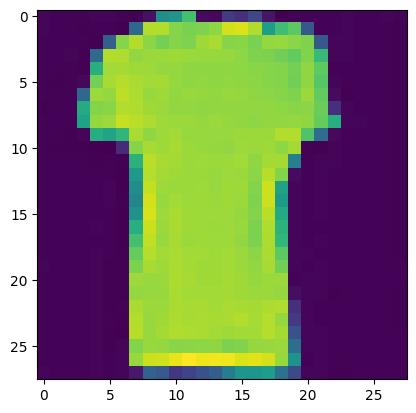

Epoch: 0   Loss: tensor(1.6117, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6410, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


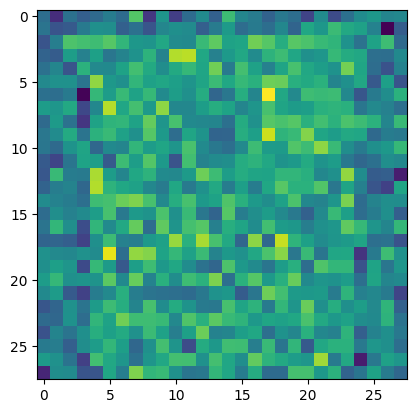

15


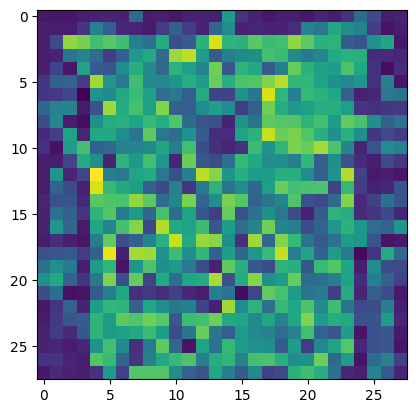

Epoch: 0  Adversarial Loss:tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)


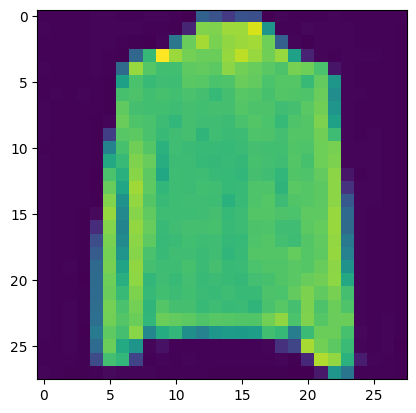

Epoch: 0   Loss: tensor(1.6548, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6579, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


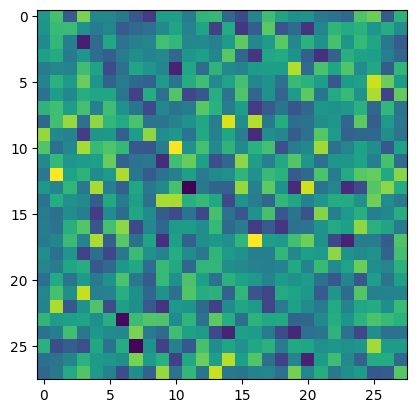

52


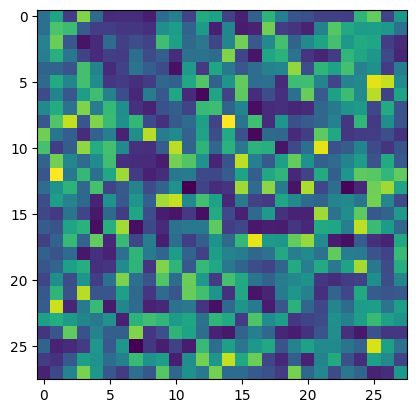

Epoch: 0  Adversarial Loss:tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


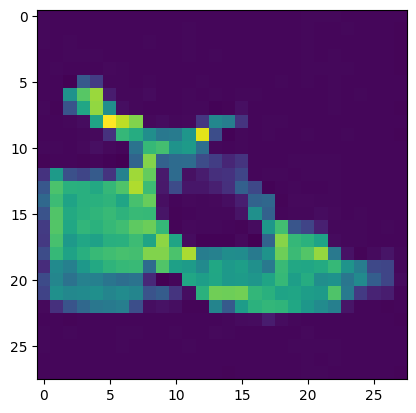

Epoch: 0   Loss: tensor(1.6856, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6729, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


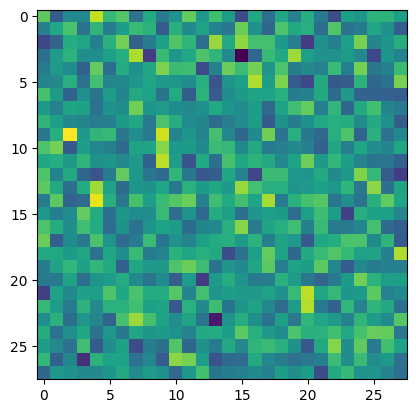

88


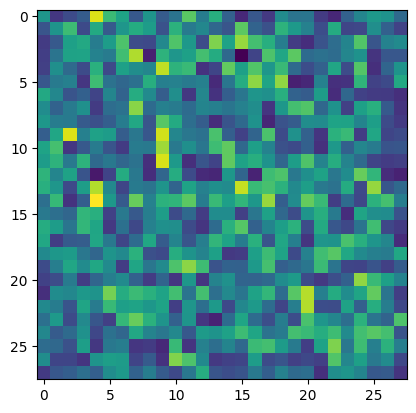

Epoch: 0  Adversarial Loss:tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


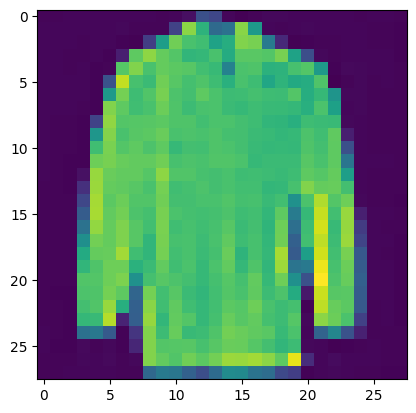

Epoch: 0   Loss: tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6997, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


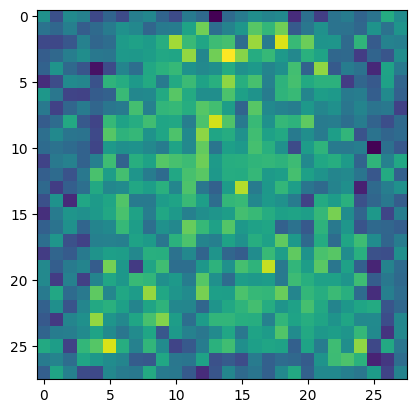

101


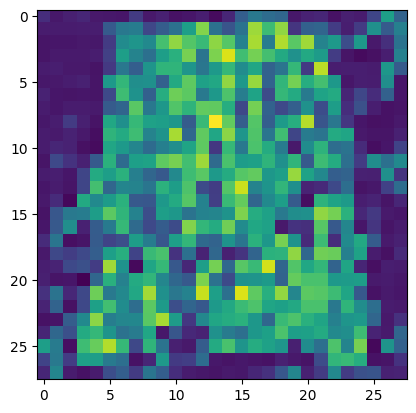

Epoch: 0  Adversarial Loss:tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


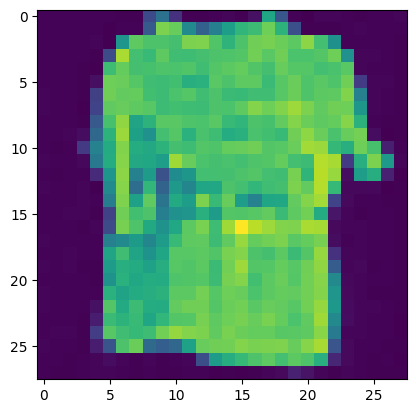

Epoch: 0   Loss: tensor(1.5119, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6035, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


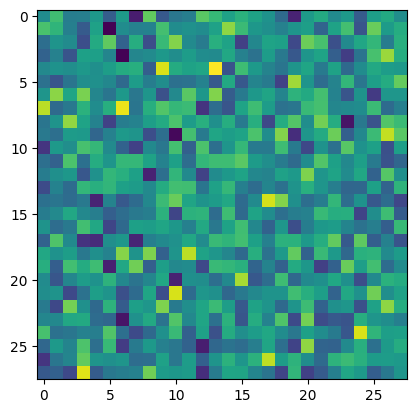

119


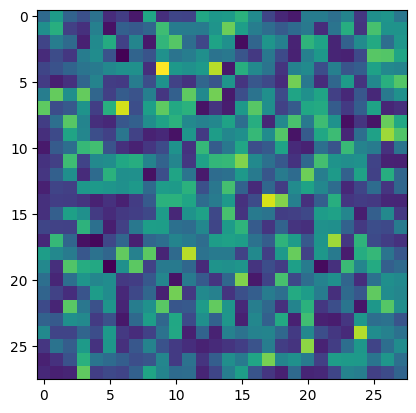

Epoch: 0  Adversarial Loss:tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)


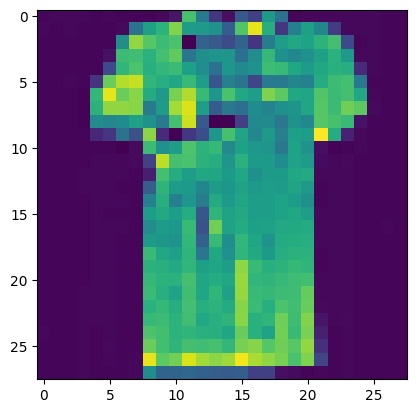

Epoch: 0   Loss: tensor(1.6132, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6340, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


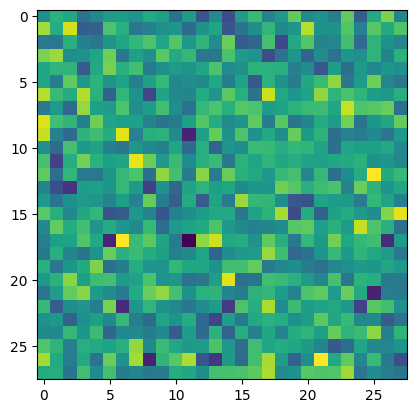

63


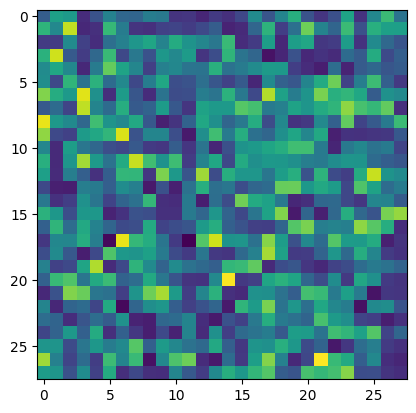

Epoch: 0  Adversarial Loss:tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


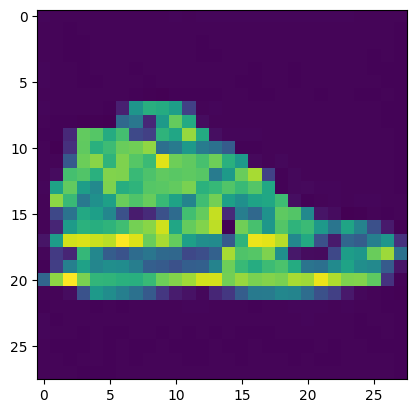

Epoch: 0   Loss: tensor(1.6526, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6593, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


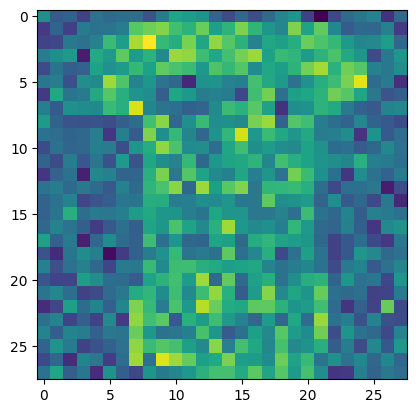

71


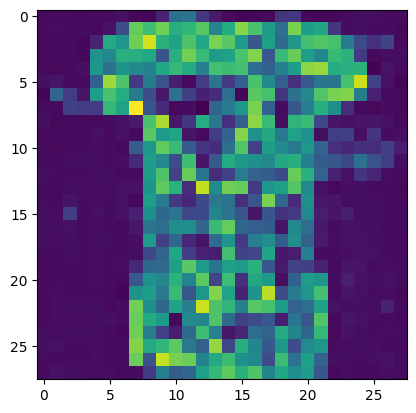

Epoch: 0  Adversarial Loss:tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)


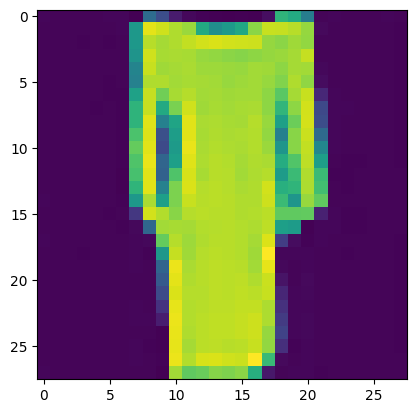

Epoch: 0   Loss: tensor(1.5944, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6366, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


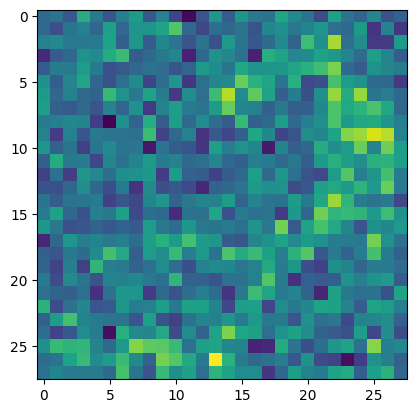

8


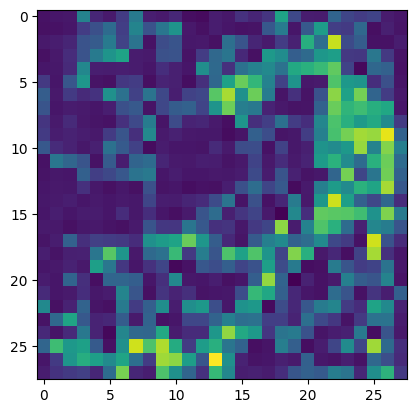

Epoch: 0  Adversarial Loss:tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>)


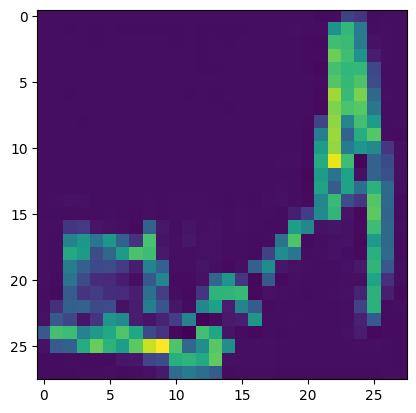

Epoch: 0   Loss: tensor(1.5588, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6216, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


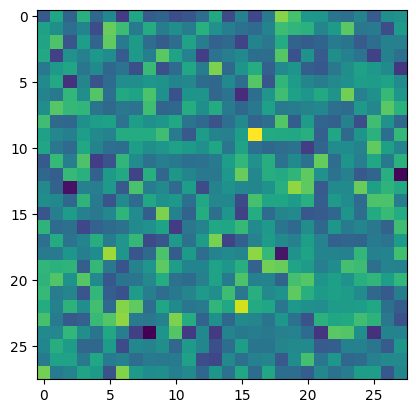

80


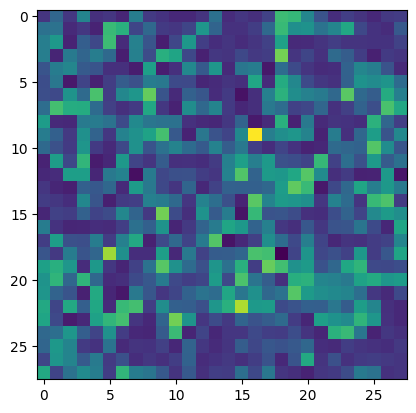

Epoch: 0  Adversarial Loss:tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)


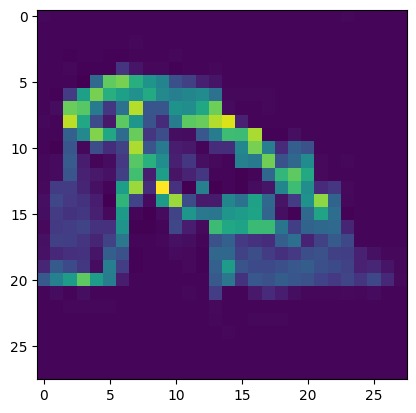

Epoch: 0   Loss: tensor(1.5442, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6167, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


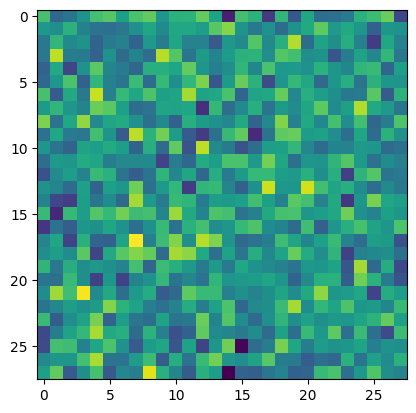

91


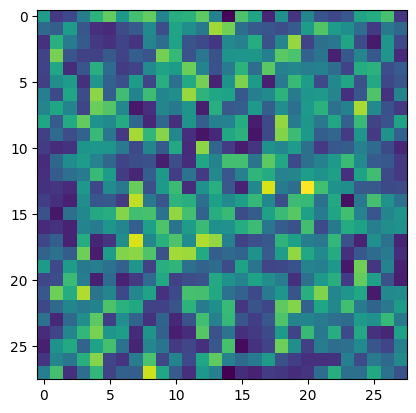

Epoch: 0  Adversarial Loss:tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


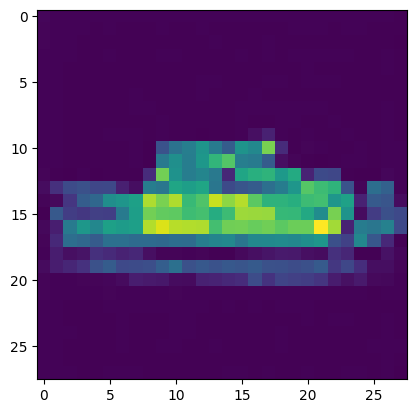

Epoch: 0   Loss: tensor(1.7313, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6908, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


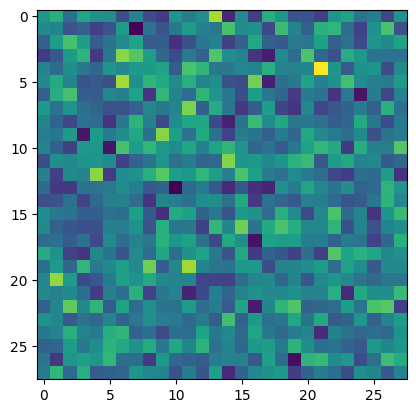

79


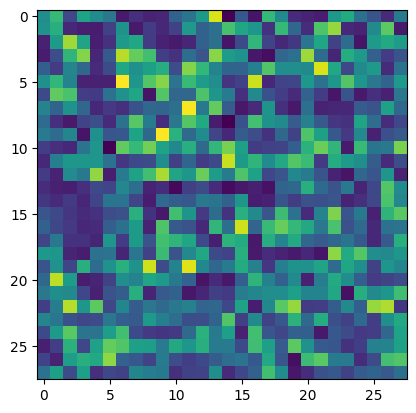

Epoch: 0  Adversarial Loss:tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


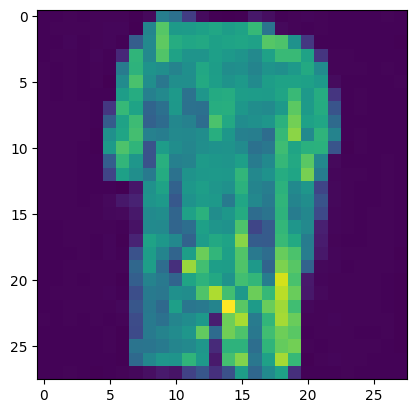

Epoch: 0   Loss: tensor(1.6627, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6646, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


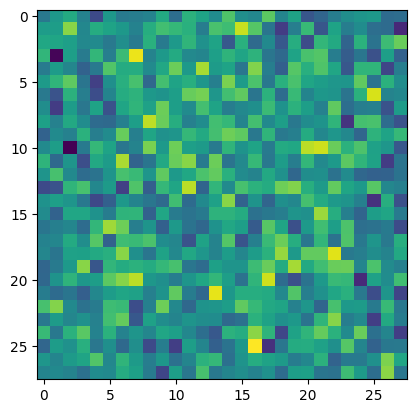

26


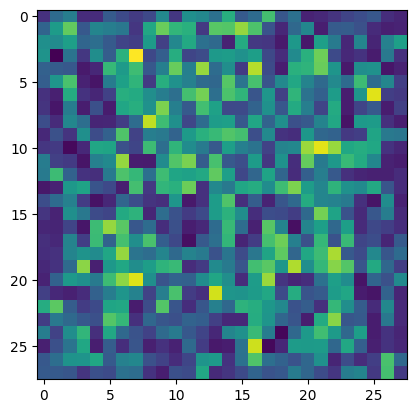

Epoch: 0  Adversarial Loss:tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)


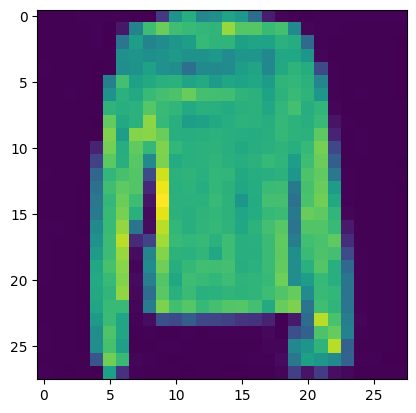

Epoch: 0   Loss: tensor(1.6812, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6699, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


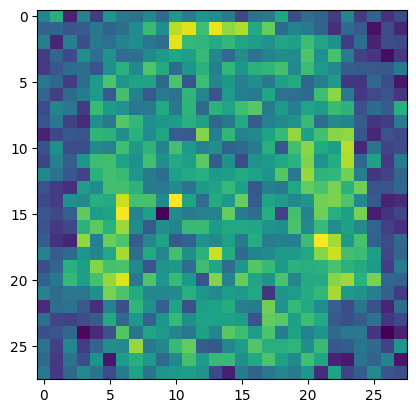

113


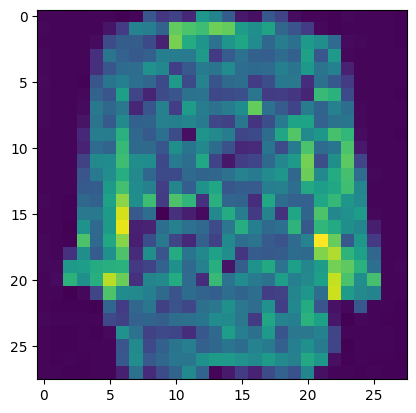

Epoch: 0  Adversarial Loss:tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


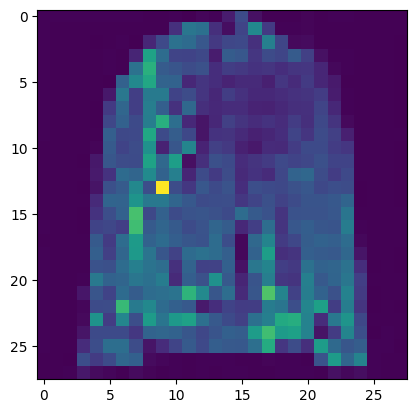

Epoch: 0   Loss: tensor(1.5313, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6117, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


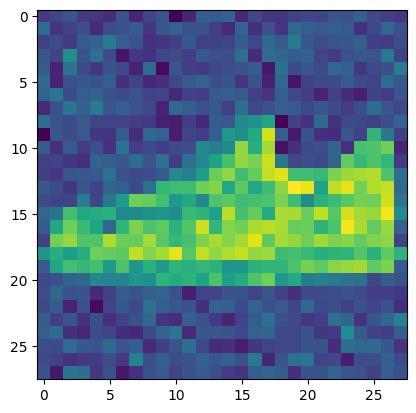

17


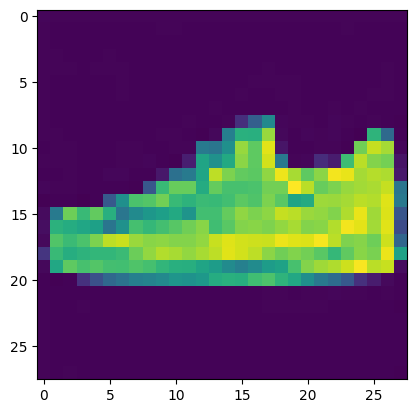

Epoch: 0  Adversarial Loss:tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>)


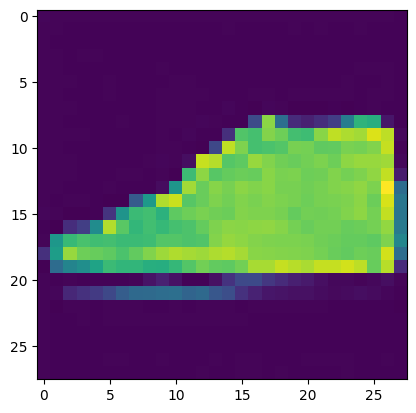

Epoch: 0   Loss: tensor(1.6819, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6718, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


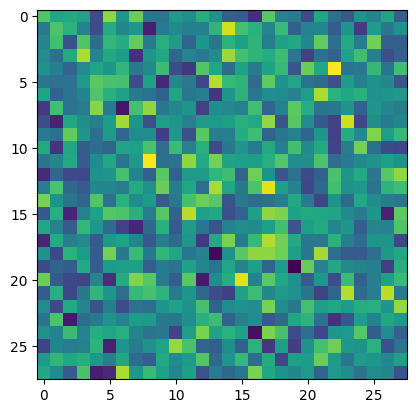

27


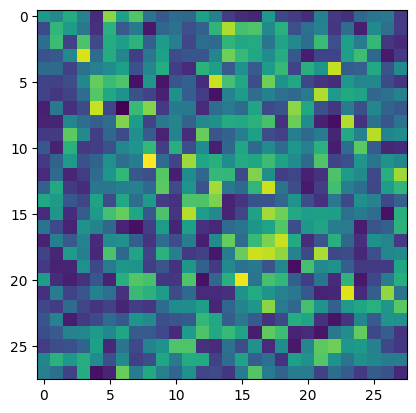

Epoch: 0  Adversarial Loss:tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)


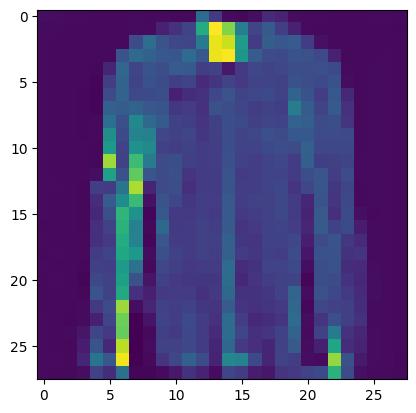

Epoch: 0   Loss: tensor(1.5684, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6240, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


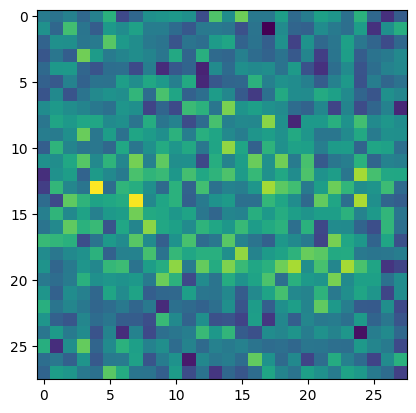

31


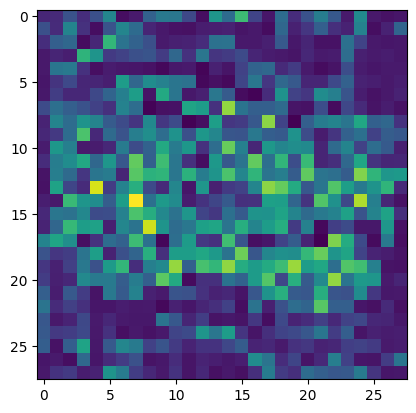

Epoch: 0  Adversarial Loss:tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)


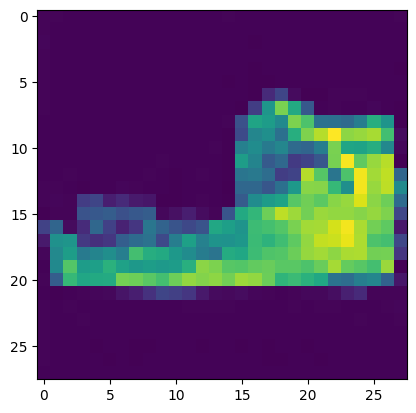

Epoch: 0   Loss: tensor(1.5591, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6219, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


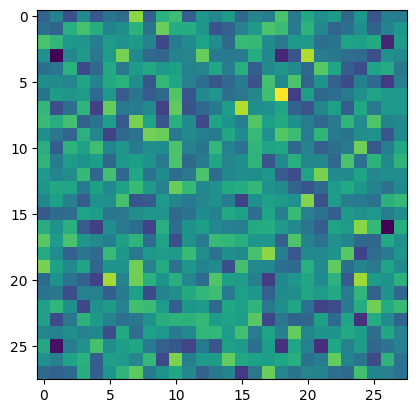

81


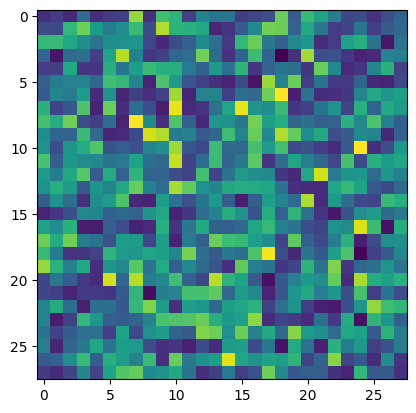

Epoch: 0  Adversarial Loss:tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)


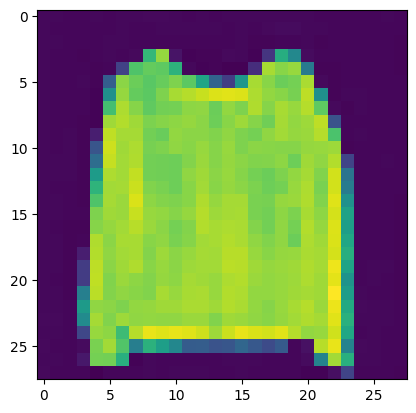

Epoch: 0   Loss: tensor(1.6388, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6542, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


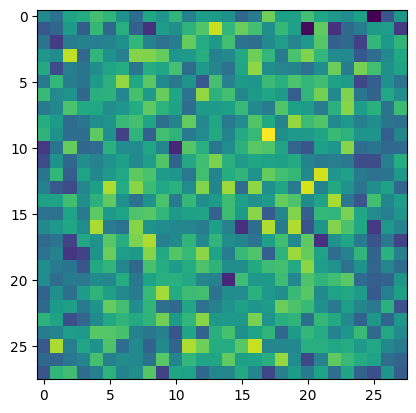

100


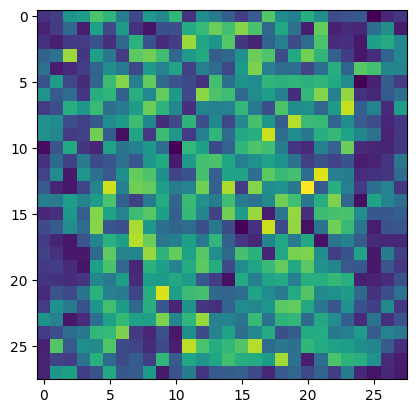

Epoch: 0  Adversarial Loss:tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


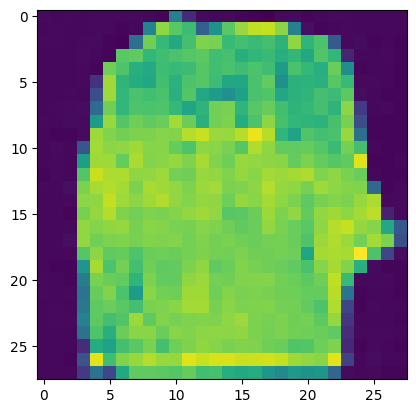

Epoch: 0   Loss: tensor(1.5000, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.5991, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


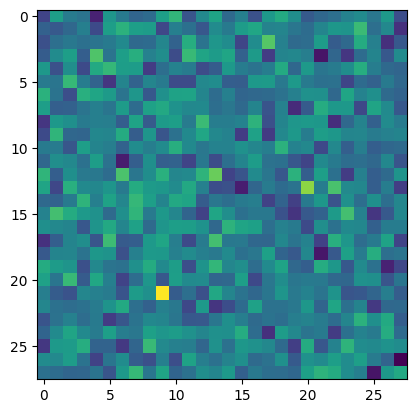

98


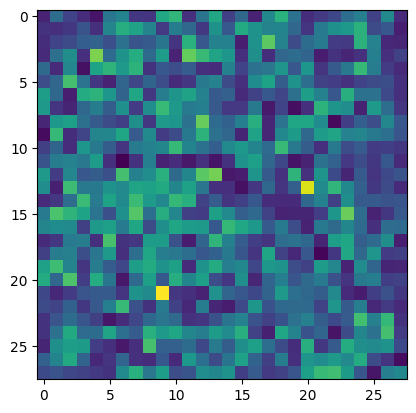

Epoch: 0  Adversarial Loss:tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


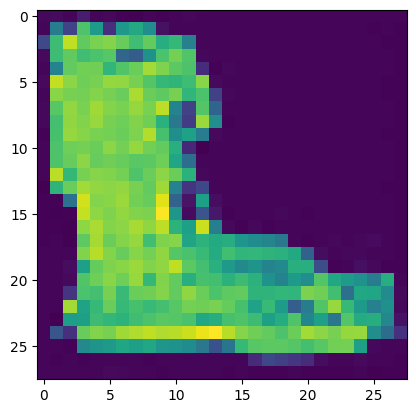

Epoch: 0   Loss: tensor(1.5716, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6278, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


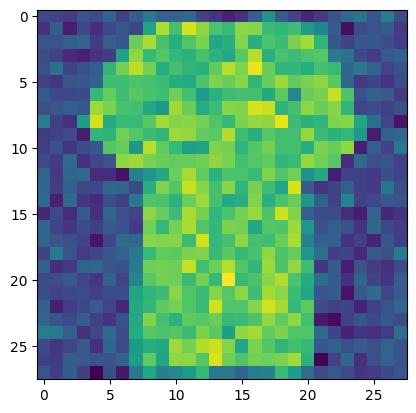

2


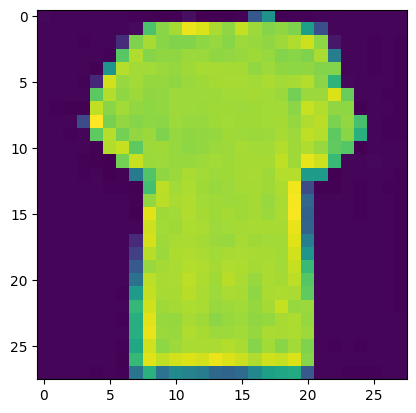

Epoch: 0  Adversarial Loss:tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)


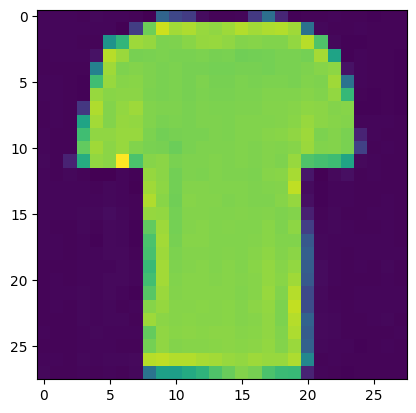

Epoch: 0   Loss: tensor(1.5357, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6117, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


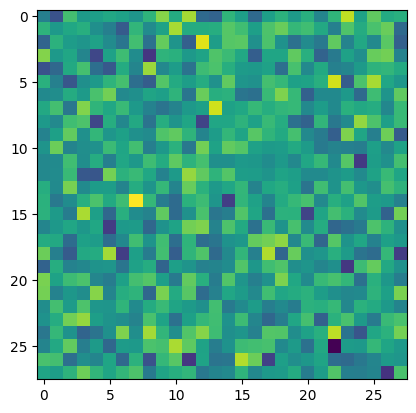

65


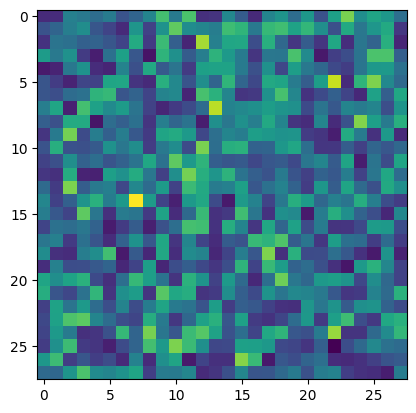

Epoch: 0  Adversarial Loss:tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)


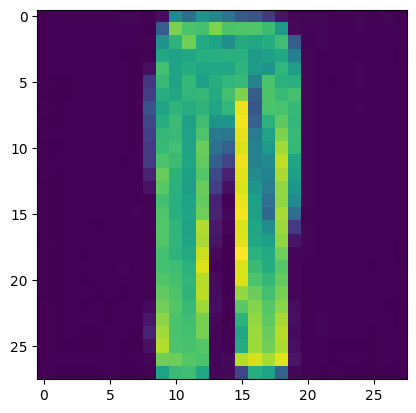

Epoch: 0   Loss: tensor(1.6314, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6519, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


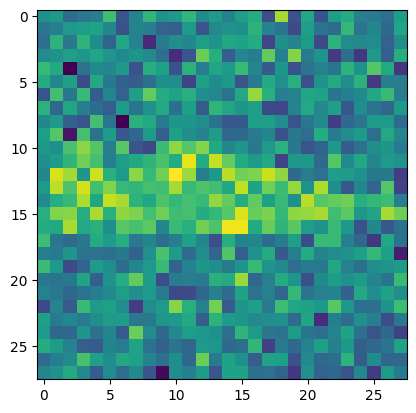

46


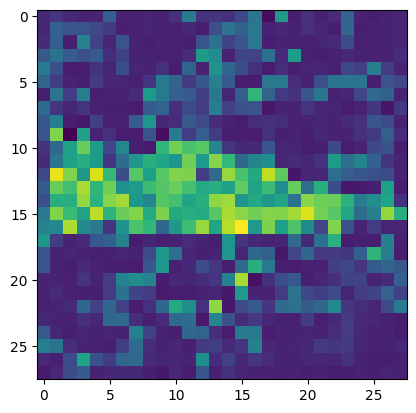

Epoch: 0  Adversarial Loss:tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)


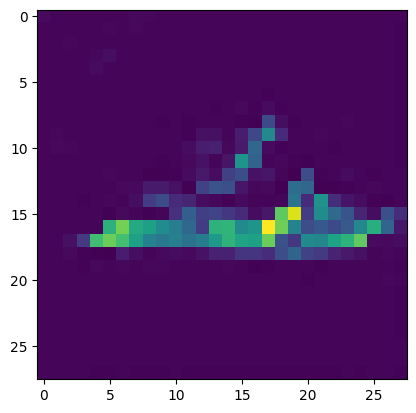

Epoch: 0   Loss: tensor(1.5523, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6195, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


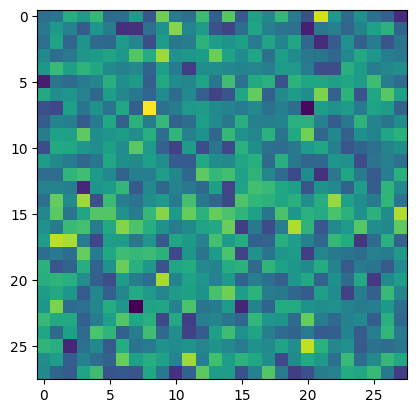

62


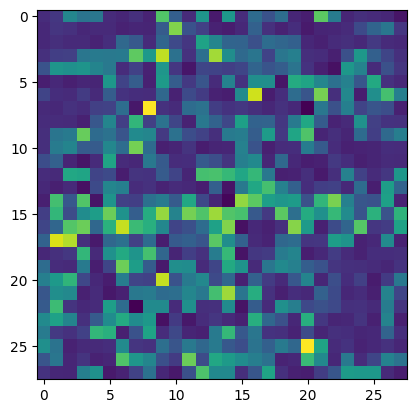

Epoch: 0  Adversarial Loss:tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)


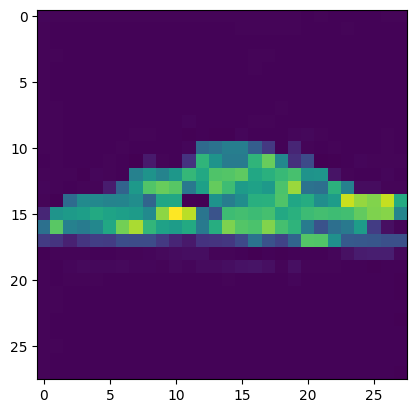

Epoch: 0   Loss: tensor(1.5080, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6010, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


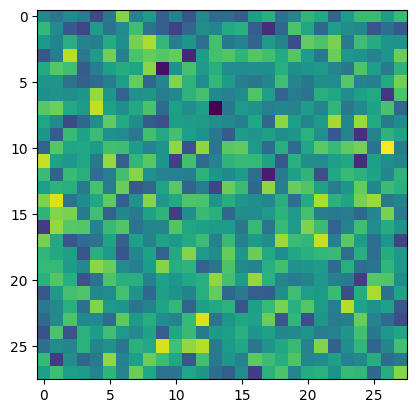

63


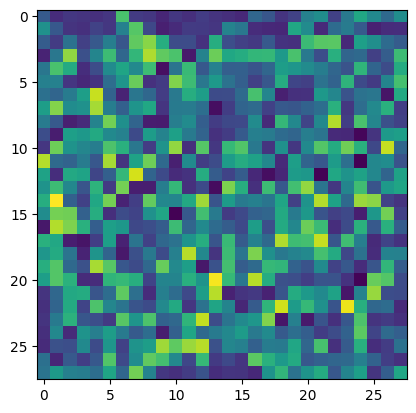

Epoch: 0  Adversarial Loss:tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)


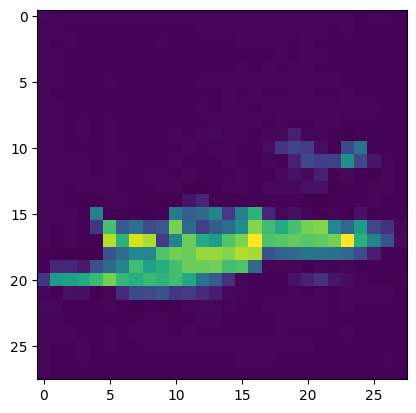

Epoch: 0   Loss: tensor(1.6354, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6536, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


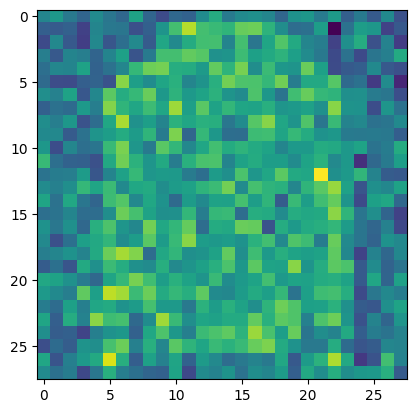

19


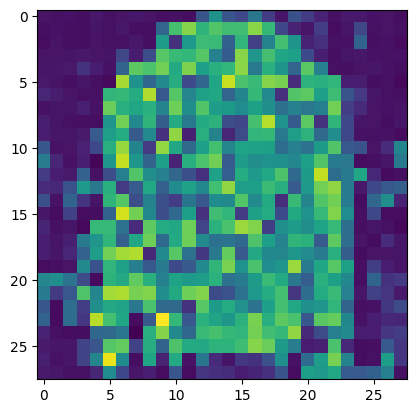

Epoch: 0  Adversarial Loss:tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


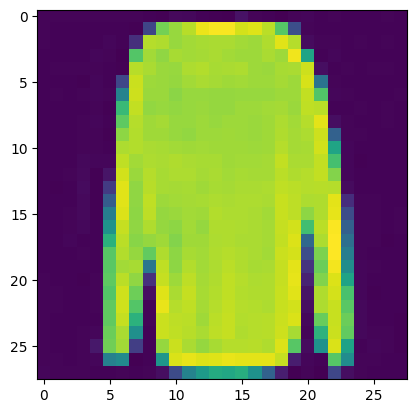

Epoch: 0   Loss: tensor(1.5486, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.6181, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([128, 1, 28, 28])


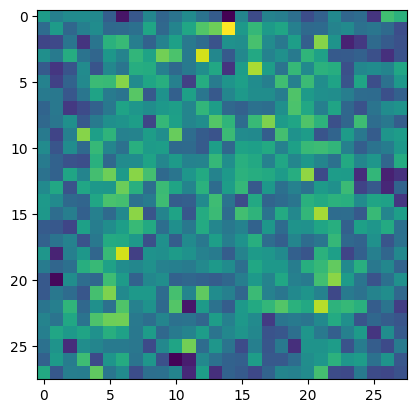

10


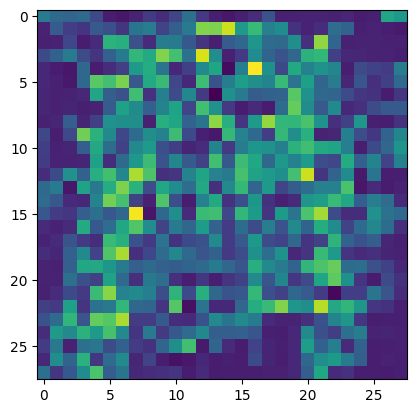

Epoch: 0  Adversarial Loss:tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [94]:
epochs = 20
save_and_sample_every = 100
disc_loss = nn.BCELoss()
dis_loss = nn.MSELoss()
l = 2.5
student_optimizer = Adam(student_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-4, betas=(0.9, 0.999))


for epoch in range(epochs):

    for step, batch in enumerate(dataloader):

      student_optimizer.zero_grad()
      discriminator_optimizer.zero_grad()
      random_index = random.randint(0, 127)

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(0, teacher_timesteps, (batch_size,), device=device).long()
      t_teacher = torch.randint(0, teacher_timesteps, (batch_size,), device=device).long()

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_teacher, noise=noise)

      #SHOW THE ORIGINAL IMAGE
      image_data = x_noisy_student[0][random_index].cpu().numpy().reshape(image_size, image_size, channels)
      plt.imshow(image_data)
      plt.show()

      predicted_noise = student_model(x_noisy_student[0], t_student)

      student_data = sample( student_model, x_noisy_student[0], image_size, timestep=student_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      print(random_index)

      #SHOW STUDENT RESULT

      image_data = student_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      # Normalizza i dati dell'immagine nel range [0, 1] se sono float
      #image_data_normalized = image_data / np.max(image_data)

      # Visualizza l'immagine normalizzata
      plt.imshow(image_data)
      plt.show()

      # Etichette per esempi reali e falsi
      real_labels = torch.ones(BATCH_SIZE, 1).to(device)
      fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

      output_real = discriminator_model(batch)

      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
      loss_fake = disc_loss(output_fake, fake_labels)

        # Calcolo totale della loss
      adversarial_loss = loss_real + loss_fake
      adversarial_loss.backward()
      discriminator_optimizer.step() #aggiorna il discriminator

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      teacher_predicted_noise = teacher_model(x_noisy_teacher[0], t_teacher)

      teacher_data = sample( teacher_model, x_noisy_teacher[0], image_size, timestep=teacher_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #SHOW TEACHER RESULT

      image_data = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      plt.imshow(image_data)
      plt.show()

      distill_loss = F.mse_loss(student_data[-1].requires_grad_(), teacher_data[-1])
      loss = l*distill_loss + loss_fake

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()


In [95]:
t_teacher = torch.rand((128, 1, 28, 28)).to(device)
teacher_data = sample(teacher_model, t_teacher, image_size=image_size, timestep=500,  batch_size=BATCH_SIZE, channels=channels)

11


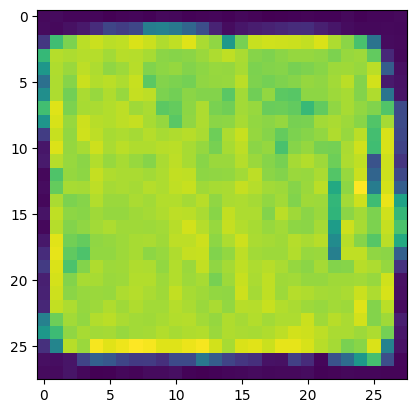

In [96]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

image_data = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data)
plt.show()

In [97]:
t_student = torch.rand((128, 1, 28, 28)).to(device)
student_data = sample(student_model, t_student, image_size=image_size, timestep=50,  batch_size=BATCH_SIZE, channels=channels)

79


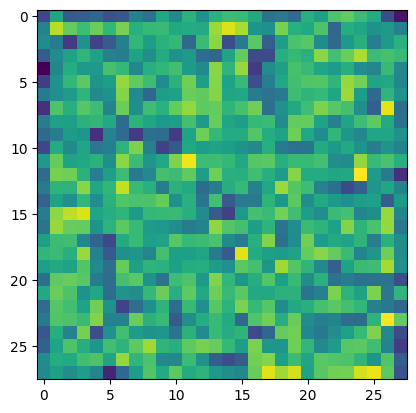

In [98]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float
image_data = student_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data)
plt.show()
#print(len(samples[-1]))#samples = [200,128,1,28,28]